In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # for pandas warning

In [3]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used


1.26.4
2.2.1
3.8.4
0.13.2


### Step-by-Step Review and Revision

### Introduction to Rare Events and Return Periods

Understanding the frequency and distribution of rare events over time and space is crucial in understanding these phenomena. One common method to describe the likelihood of rare events, such as natural disasters (and possible large scale violence), is through return periods. A return period is the average interval between occurrences of an event of a certain intensity or size.

For example, a region with a 100-year return period for an event means that, on average, such an event is expected to occur once every 100 years. However, this does not mean the event will occur exactly every 100 years; it is a statistical average.

In our analysis, we focus on the fatalities per 100,000 people across different grid cells in Mali (PRIO gird cells of roughly  $55km  \times 55km $$). By calculating return periods and cumulative distributions, we can gain insights into the frequency and distribution of extreme events, such as high-fatality incidents. As such, this analysis helps us understand what constiture a rare event.

### Key Concepts and Terms:
Here are the key concepts and terms we'll be working with:


1. **Grid Cell (Cell):**
    - A grid cell represents a specific geographical area within Mali. Each cell is uniquely identified and corresponds to a particular latitude and longitude. Unless the borders of the country change, each grid cell is observed once at each time period.

2. **Voxel:**
    - A voxel is an observation of a grid cell at a particular point in time. It combines spatial and temporal information, representing a value observed in a grid cell during a specific time period.

3. **Time Period:**
    - A time period represents the temporal dimension of our data. In this case, we aggregate data to the yearly level, so each time period corresponds to one year.


### Data Processing and Feature Creation

To begin our analysis, we need to process data on Mali, aggregate it to a yearly level, and create a new feature called fatalities_per_100k. This process involves several steps to ensure our data is well-prepared for further analysis. 

**Steps in Data Processing:**

1. **Loading the Data:**
    - We start by loading the dataset, which contains observations of various features at different times (monthly or yearly) for different grid cells in Mali.

2. **Aggregating to Yearly Level:**
    - Since some features are observed monthly, we aggregate these monthly values to obtain yearly values. This involves summing up monthly values for each year while retaining the yearly features.

3. **Creating the fatalities_per_100k Feature:**
    - We create a new feature called "fatalities_per_100k," representing the number of fatalities per 100,000 people in each grid cell for each year. This is calculated using the total fatalities and population data for each cell and time period.

4. **Ensuring Robustness:**
    - We include checks and handle cases where the population might be zero to avoid division errors.

By following these steps, we ensure that our data is well-structured and ready for further analysis. This preparation provides insights into the spatial and temporal distribution of significant events in Mali.

In [4]:
# if data not there, activate your viewser env and run src/dataloaders/get_mali.py

def get_data(PATH_RAW):
    """
    Load the data from the specified file path into a pandas DataFrame, keep relevant columns,
    and streamline column names.
    
    Parameters:
    file_path (str): The path to the pickle file containing the data
    
    Returns:
    pd.DataFrame: The cleaned data as a pandas DataFrame
    """
    # Load the data
    df = pd.read_pickle(PATH_RAW)
        
    return df

In [5]:
def aggregate_monthly_to_yearly(df):
    """
    Aggregate monthly data to yearly level while keeping all columns intact.
    
    Parameters:
    df (pd.DataFrame): The data as a pandas DataFrame
    
    Returns:
    pd.DataFrame: Data aggregated at the yearly level
    """
    # columns to group by
    grouping_columns = ['pg_id', 'year_id']

    # Columns that are monthly and need to be summed
    monthly_columns = ['sb_best', 'ns_best', 'os_best']  # Add more columns if needed
    
    # Group by 'pg_id' and 'year_id', summing the monthly columns
    df_yearly_summed = df.groupby(grouping_columns)[monthly_columns].sum().reset_index()
    
    # Identify yearly columns by excluding the monthly columns and grouping columns
    yearly_columns = [col for col in df.columns if col not in monthly_columns + grouping_columns]

    # Get the first occurrence of the yearly columns since they don't change
    df_yearly_intact = df.groupby(grouping_columns)[yearly_columns].first().reset_index()
    
    # Merge the summed monthly data with the yearly data
    df_yearly = pd.merge(df_yearly_summed, df_yearly_intact, on=['pg_id', 'year_id'])
    
    return df_yearly


In [6]:
def calculate_fatalities_per_100k(df):
    """
    Calculate fatalities per 100,000 people.
    
    Parameters:
    df (pd.DataFrame): The data aggregated at the yearly level
    
    Returns:
    pd.DataFrame: Data with the new column for fatalities per 100,000 people
    """

    df['fatalities_per_100k'] = (df['sb_best'] / df['pop_gpw_sum']) * 100000

    # fill potential NaN values with 0
    df['fatalities_per_100k'] = df['fatalities_per_100k'].fillna(0)

    return df

In [7]:
def post_process_data(file_path):
    """
    Load, aggregate, and process the data.
    
    Parameters:
    file_path (str): The path to the pickle file containing the data
    
    Returns:
    pd.DataFrame: The processed data
    """
    # Load the data
    df = get_data(file_path)
   
    # Aggregate monthly data to yearly
    df_yearly = aggregate_monthly_to_yearly(df)

    # Calculate fatalities per 100,000 people
    df_processed = calculate_fatalities_per_100k(df_yearly)
    
    # Keep only relevant columns and rename them
    df_processed = df_processed[['pg_id', 'year_id', 'row', 'col', 'fatalities_per_100k']]
    df_processed.columns = ['cell_id', 'year_id', 'row', 'col', 'fatalities_per_100k']
    
    return df_processed

In [8]:
# Specify the file path
PATH_RAW = '/home/simon/Documents/scripts/VIEWS_FAO_index/data/raw_viewser/simon_mali_01_viewser_df.pkl'

# Post-process the data
df = post_process_data(PATH_RAW)

# Display results
df.sample(100)

,cell_id,year_id,row,col,fatalities_per_100k
6224,152999,2018,213,359,0.0
8526,155167,2010,216,367,0.0
5332,152273,2001,212,353,0.0
6844,153718,2008,214,358,0.0
11117,158043,2011,220,363,0.0
...,...,...,...,...,...
1878,148664,2012,207,344,0.0
2786,149394,2010,208,354,0.0
2176,149377,1995,208,337,0.0
11595,158759,1999,221,359,0.0


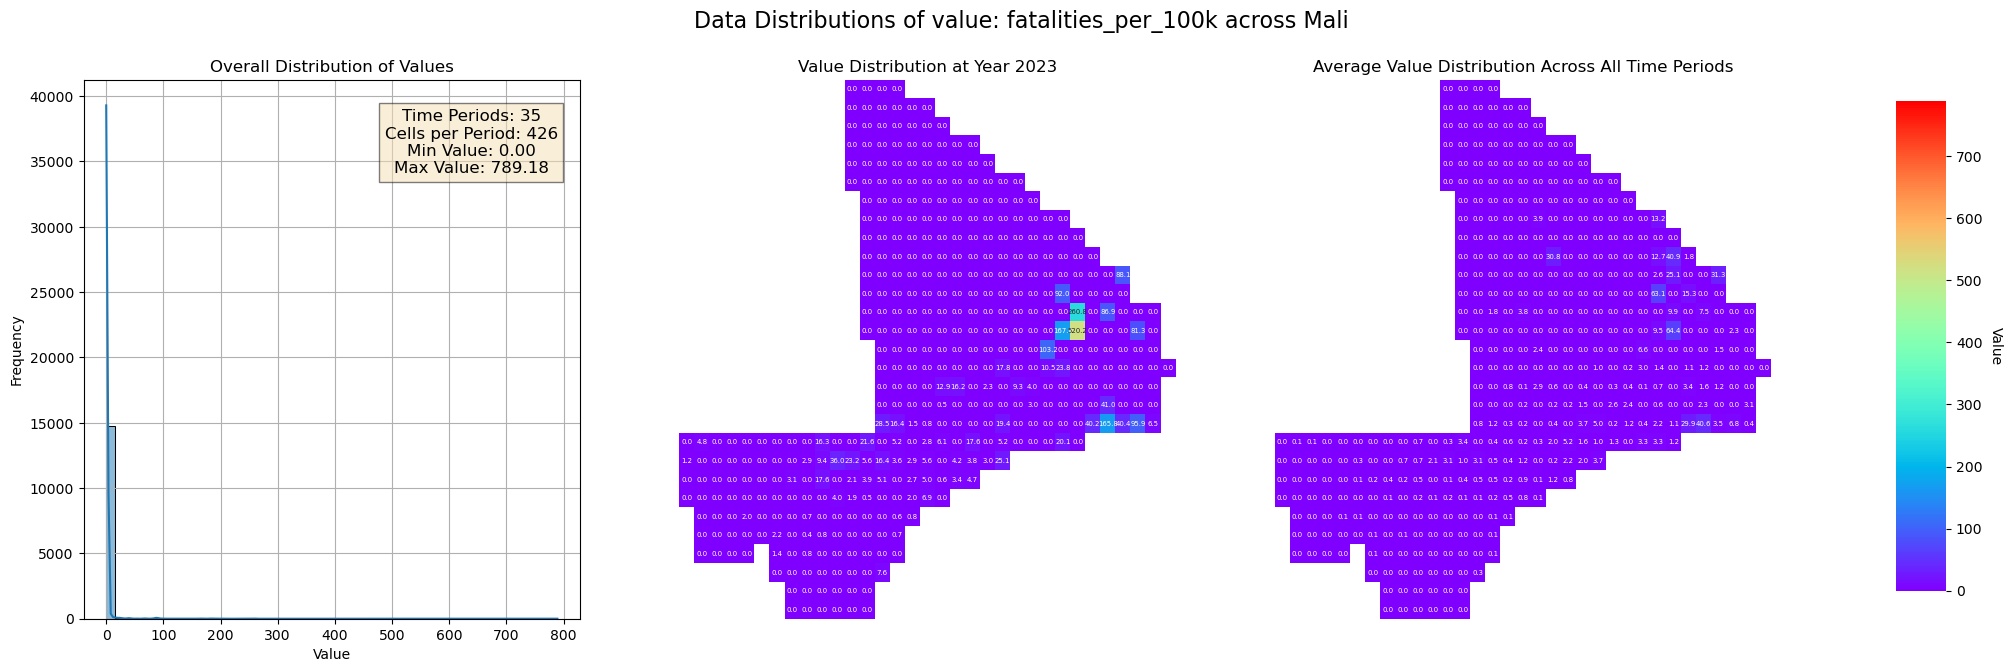

In [9]:
def plot_data_distributions(data, value_col='fatalities_per_100k', year_id=1989):
    """
    Plots the distribution of values in the dataset, the distribution across one time period as a 2D heatmap,
    and the average distribution across time as a 2D heatmap, all side by side.
    
    Parameters:
    data (pd.DataFrame): The voxel data with columns ['cell_id', 'year_id', 'row', 'col', value_col]
    value_col (str): The column name to be used for plotting values
    year_id (int): The specific year to plot for the time slice heatmap
    """
    fig, axes = plt.subplots(1, 3, figsize=(25, 7))
    
    font_large = 18
    font_mid = 16
    font_small = 14

    # Plot the overall distribution of values
    sns.histplot(data[value_col], bins=50, kde=True, ax=axes[0])
    axes[0].set_title('Overall Distribution of Values')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)
    
    # Plot the distribution of values for one time period (e.g., year_id = 1989)
    time_slice = data[data['year_id'] == year_id]
    if 'row' in data.columns and 'col' in data.columns:
        pivot_time_slice = time_slice.pivot(index='row', columns='col', values=value_col)
    else:
        pivot_time_slice = time_slice.pivot(index='cell_id', columns='year_id', values=value_col)

    sns.heatmap(pivot_time_slice, annot=True, fmt=".1f", cmap='rainbow', ax=axes[1], vmin=data[value_col].min(), vmax=data[value_col].max(), cbar=False, annot_kws={"size": 5})
    axes[1].set_title(f'Value Distribution at Year {year_id}')
    axes[1].invert_yaxis()  # Invert the y-axis
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    axes[1].tick_params(left=False, bottom=False)
    axes[1].set_xticklabels([])
    axes[1].set_yticklabels([])
    
    # Plot the average distribution across all time periods
    if 'row' in data.columns and 'col' in data.columns:
        avg_values = data.groupby(['row', 'col'])[value_col].mean().reset_index()
        pivot_avg_values = avg_values.pivot(index='row', columns='col', values=value_col)
    else:
        avg_values = data.groupby('cell_id')[value_col].mean().reset_index()
        pivot_avg_values = avg_values.pivot(index='cell_id', columns='cell_id', values=value_col)
    
    sns.heatmap(pivot_avg_values, annot=True, fmt=".1f", cmap='rainbow', ax=axes[2], vmin=data[value_col].min(), vmax=data[value_col].max(), cbar=False, annot_kws={"size": 5})
    axes[2].set_title('Average Value Distribution Across All Time Periods')
    axes[2].invert_yaxis()  # Invert the y-axis
    axes[2].set_xlabel('')
    axes[2].set_ylabel('')
    axes[2].tick_params(left=False, bottom=False)
    axes[2].set_xticklabels([])
    axes[2].set_yticklabels([])

    # set a common colorbar for the two heatmaps
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(axes[1].collections[0], cax=cbar_ax)
    cbar.outline.set_visible(False)
    cbar.set_label('Value', rotation=270, labelpad=15)

    # set the overall title
    fig.suptitle(f'Data Distributions of value: {value_col} across Mali', fontsize=16)

    # Add text box with additional information
    num_time_periods = data['year_id'].nunique()
    num_cells = data['cell_id'].nunique()
    min_value = data[value_col].min()
    max_value = data[value_col].max()
    textstr = '\n'.join((
        f'Time Periods: {num_time_periods}',
        f'Cells per Period: {num_cells}',
        f'Min Value: {min_value:.2f}',
        f'Max Value: {max_value:.2f}',
    ))

    # Add text box below the plots
    plt.figtext(0.28, 0.75, textstr, wrap=True, horizontalalignment='center', fontsize=12, bbox=dict(facecolor='wheat', alpha=0.5))

    #plt.tight_layout()
    plt.show()

# Plot the data distributions using the processed dataset
plot_data_distributions(df, year_id= 2023)

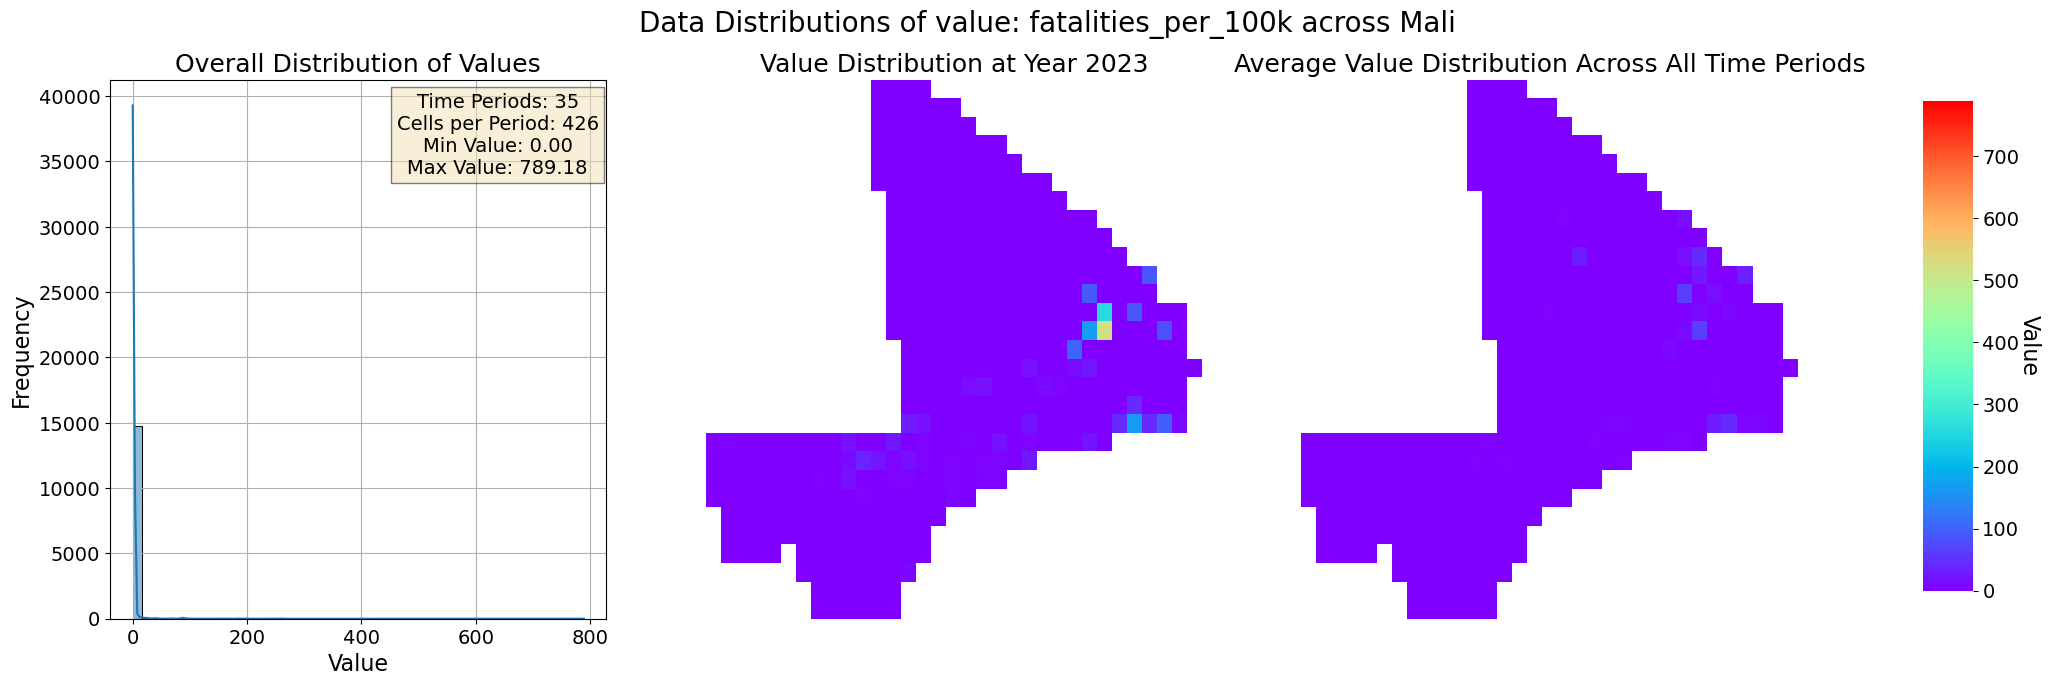

In [10]:
def plot_data_distributions(data, value_col='fatalities_per_100k', year_id=1989):
    """
    Plots the distribution of values in the dataset, the distribution across one time period as a 2D heatmap,
    and the average distribution across time as a 2D heatmap, all side by side.
    
    Parameters:
    data (pd.DataFrame): The voxel data with columns ['cell_id', 'year_id', 'row', 'col', value_col]
    value_col (str): The column name to be used for plotting values
    year_id (int): The specific year to plot for the time slice heatmap
    """
    fig, axes = plt.subplots(1, 3, figsize=(25, 7))
    
    font_large = 18
    font_mid = 16
    font_small = 14

    # Plot the overall distribution of values
    sns.histplot(data[value_col], bins=50, kde=True, ax=axes[0])
    axes[0].set_title('Overall Distribution of Values', fontsize=font_large)
    axes[0].set_xlabel('Value', fontsize=font_mid)
    axes[0].set_ylabel('Frequency', fontsize=font_mid)
    axes[0].tick_params(axis='both', which='major', labelsize=font_small)
    axes[0].grid(True)
    
    # Plot the distribution of values for one time period (e.g., year_id = 1989)
    time_slice = data[data['year_id'] == year_id]
    if 'row' in data.columns and 'col' in data.columns:
        pivot_time_slice = time_slice.pivot(index='row', columns='col', values=value_col)
    else:
        pivot_time_slice = time_slice.pivot(index='cell_id', columns='year_id', values=value_col)

    sns.heatmap(pivot_time_slice, annot=False, fmt=".1f", cmap='rainbow', ax=axes[1], vmin=data[value_col].min(), vmax=data[value_col].max(), cbar=False, annot_kws={"size": 5})
    axes[1].set_title(f'Value Distribution at Year {year_id}', fontsize=font_large)
    axes[1].invert_yaxis()  # Invert the y-axis
    axes[1].set_xlabel('', fontsize=font_mid)
    axes[1].set_ylabel('', fontsize=font_mid)
    axes[1].tick_params(left=False, bottom=False)
    axes[1].set_xticklabels([])
    axes[1].set_yticklabels([])
    
    # Plot the average distribution across all time periods
    if 'row' in data.columns and 'col' in data.columns:
        avg_values = data.groupby(['row', 'col'])[value_col].mean().reset_index()
        pivot_avg_values = avg_values.pivot(index='row', columns='col', values=value_col)
    else:
        avg_values = data.groupby('cell_id')[value_col].mean().reset_index()
        pivot_avg_values = avg_values.pivot(index='cell_id', columns='cell_id', values=value_col)
    
    sns.heatmap(pivot_avg_values, annot=False, fmt=".1f", cmap='rainbow', ax=axes[2], vmin=data[value_col].min(), vmax=data[value_col].max(), cbar=False, annot_kws={"size": 5})
    axes[2].set_title('Average Value Distribution Across All Time Periods', fontsize=font_large)
    axes[2].invert_yaxis()  # Invert the y-axis
    axes[2].set_xlabel('', fontsize=font_mid)
    axes[2].set_ylabel('', fontsize=font_mid)
    axes[2].tick_params(left=False, bottom=False)
    axes[2].set_xticklabels([])
    axes[2].set_yticklabels([])

    # set a common colorbar for the two heatmaps
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(axes[1].collections[0], cax=cbar_ax)
    cbar.outline.set_visible(False)
    cbar.set_label('Value', rotation=270, labelpad=15, fontsize=font_mid)
    cbar.ax.tick_params(labelsize=font_small)

    # set the overall title
    fig.suptitle(f'Data Distributions of value: {value_col} across Mali', fontsize=font_large+2)

    # Add text box with additional information
    num_time_periods = data['year_id'].nunique()
    num_cells = data['cell_id'].nunique()
    min_value = data[value_col].min()
    max_value = data[value_col].max()
    textstr = '\n'.join((
        f'Time Periods: {num_time_periods}',
        f'Cells per Period: {num_cells}',
        f'Min Value: {min_value:.2f}',
        f'Max Value: {max_value:.2f}',
    ))

    # Add text box below the plots
    plt.figtext(0.28, 0.75, textstr, wrap=True, horizontalalignment='center', fontsize=font_small, bbox=dict(facecolor='wheat', alpha=0.5))

    #plt.tight_layout()
    plt.show()

# Plot the data distributions using the processed dataset
plot_data_distributions(df, year_id= 2023)


### Calculating the Cumulative Distribution of Voxel Values

Now we calculate the cumulative distribution of values across all voxels.

1. **Calculate Value Frequencies**:
    - We begin by counting the occurrences of each unique value in the dataset, sorting these counts in descending order. This step clarifies the distribution of individual values.

2. **Compute Cumulative Distribution**:
    - Next, the function computes the cumulative sum of these sorted counts. The cumulative sum provides the total count of voxels with values greater than or equal to each unique value. Mathematically, if $f(i)$ is the frequency of value $i$, the cumulative distribution $F(i)$ is given by:
    
    $$
    F(i) = \sum_{j \geq i} f(j)
    $$

    where $j$ represents each unique value greater than or equal to \( i \).

3. **Return the Cumulative Distribution**:
    - Finally, the function returns the cumulative distribution

In [11]:
def calculate_cumulative_distribution(data, value_col='fatalities_per_100k'):
    """
    Calculate the cumulative distribution of values across all voxels.
    
    Parameters:
    data (pd.DataFrame): The voxel data with columns ['cell_id', 'year_id', 'row', 'col', value_col]
    value_col (str): The column name for which to calculate the cumulative distribution
    
    Returns:
    pd.Series: Cumulative counts of voxels with value >= each unique value
    """
    # Check if the value_col exists in the dataframe
    if value_col not in data.columns:
        raise ValueError(f"Column '{value_col}' does not exist in the dataframe.")
    
    # Calculate the frequency of each value
    value_counts = data[value_col].value_counts().sort_index(ascending=False)
    
    # Check if value_counts is not empty
    if value_counts.empty:
        raise ValueError(f"No values found in column '{value_col}' to calculate the cumulative distribution.")
    
    # Calculate the cumulative distribution
    cumulative_distribution = value_counts.cumsum()
    
    return cumulative_distribution


In [12]:
cumulative_distribution = calculate_cumulative_distribution(df, value_col='fatalities_per_100k')

# Display the cumulative distribution
cumulative_distribution.sample(10)


fatalities_per_100k
18.873556     166
151.173756     36
9.984808      221
6.671745      267
54.457947      96
3.043402      367
15.631997     182
2.583918      391
17.581053     174
165.803159     33
Name: count, dtype: int64

### Calculating Probabilities $p_i$ and $P_i$

Now we need to calculate two key probabilities for each unique value in the dataset:
- $p_i$: The probability of drawing a voxel with a value greater than or equal to $i$.
- $P_i$: The probability of observing at least one voxel with a value greater than or equal to $i$ in a random time period.

1. **Calculate Total Number of Voxels**:
    - The function first determines the total number of voxels in the dataset, which is essential for subsequent probability calculations.

2. **Calculate Number of Unique Grid Cells per Time Period**:
    - Next, it identifies the number of unique grid cells observed in each time period.

3. **Calculate $p_i$**:
    - $p_i$ represents the probability of drawing a voxel with a value greater than or equal to $i$. It is calculated by dividing the cumulative count of values by the total number of voxels:

    $$
    p_i = \frac{T_i}{N \times M}
    $$

    where $T_i$ is the cumulative count of values, $N$ is the number of grid cells, and $M$ is the number of time periods.

4. **Calculate $P_i$**:
    - $P_i$ is the probability of observing at least one voxel with a value greater than or equal to $i$ in any given time period. If $h$ denotes the number of cells per time period, the formula is:

    $$
    P_i = 1 - (1 - p_i)^h
    $$

    This formula is based on the probability of achieving at least one success in a series of independent trials.

5. **Combine into a DataFrame**:
    - Finally, the function creates a pandas DataFrame containing the values, $p_i$, and $P_i$ for straightforward interpretation and analysis.

These probabilities are crucial for understanding the distribution of values in the dataset and for making informed decisions based on the likelihood of various value occurrences.

In [13]:
def calculate_probabilities(cumulative_distribution, data, value_col='fatalities_per_100k'):
    """
    Calculate the probabilities p_i and P_i for each value i.
    
    Parameters:
    cumulative_distribution (pd.Series): Cumulative counts of voxels with value >= each unique value
    data (pd.DataFrame): The voxel data with columns ['cell_id', 'year_id', 'row', 'col']
    value_col (str): The column name for the values
    
    Returns:
    pd.DataFrame: DataFrame containing values, p_i, and P_i
    """
    # Calculate total number of voxels
    total_voxels = len(data)
    
    # Number of unique grid cells observed at each time period
    num_cells_per_time_period = data['cell_id'].nunique()
    
    # Calculate p_i for each value
    p_i = cumulative_distribution / total_voxels
    
    # Calculate P_i for each value
    P_i = 1 - (1 - p_i) ** num_cells_per_time_period
    
    # Combine into a DataFrame
    probabilities = pd.DataFrame({
        'value': cumulative_distribution.index,
        'p_i': p_i.values,
        'P_i': P_i.values
    })
    
    return probabilities


In [14]:
# Calculate probabilities
probabilities = calculate_probabilities(cumulative_distribution, df, value_col='fatalities_per_100k')

# Display the probabilities DataFrame
print(probabilities.sample(10))


         value       p_i       P_i
267   2.146424  0.027096  0.999992
60   65.349211  0.006304  0.932405
70   41.128623  0.007109  0.952136
189   6.427724  0.018511  0.999651
190   6.346039  0.018645  0.999670
255   2.619201  0.026157  0.999988
331   0.508762  0.034541  1.000000
194   6.086804  0.018913  0.999707
66   47.943105  0.006707  0.943117
293   1.373079  0.029779  0.999997


### Calculating Expected Number of Time Periods to Survey ($E_i$)

This function calculates the expected number of time periods required to find at least one voxel with a value greater than or equal to $i$. This approach is likely the most appropriate way to define return periods in our context.

**Steps:**

1. **Calculate $E_i$:**
    - $E_i$ represents the expected number of time periods needed to find at least one voxel with a value greater than or equal to $i$. It is calculated using the formula:
    
    $$
    E_i = \frac{1}{P_i}
    $$
    
    where $P_i$ is the probability of observing one or more voxels with a value $\geq i$ in a random time period.

2. **Return $E_i$:**
    - The function returns $E_i$ as a pandas Series, providing a measure of how often one might need to survey time periods to find significant values.

Understanding the expected number of time periods to check ($E_i$) is crucial for planning and decision-making. It helps estimate the frequency of observations needed to detect significant events or values in the dataset. This method is likely the best way to define return periods for our use case, which involves tracking fatalities per 100,000 people in one PRIO-grid year.

In [15]:
def calculate_expected_time_periods(P_i):
    """
    Calculate the expected number of time periods to check (E_i) for each value i.
    
    Parameters:
    P_i (pd.Series): Probability of seeing one or more voxels with value >= i in a random time period
    
    Returns:
    pd.Series: Expected number of time periods to check for each value
    """
    # Calculate E_i for each value
    E_i = 1 / P_i
    
    return E_i


In [16]:
# Calculate expected number of time periods (E_i)
E_i = calculate_expected_time_periods(probabilities['P_i'])

# Add E_i to the probabilities DataFrame
probabilities['E_i'] = E_i

# Display the probabilities DataFrame
print(probabilities.head())


        value       p_i       P_i        E_i
0  789.176313  0.000067  0.028168  35.501207
1  560.005095  0.000134  0.055544  18.003588
2  520.154836  0.000201  0.082151  12.172636
3  459.899947  0.000335  0.133143   7.510729
4  354.488896  0.000469  0.181308   5.515486


### Calculating Expected Number of Voxels to Draw ($E_{i}^{\text{voxels}}$)

Now we calculate the expected number of voxels to draw to observe at least one voxel with a value greater than or equal to $i$. This helps illustrate why using the number of individual voxels surveyed can provide a misleading "return period."

**Steps:**

1. **Calculate $E_{i}^{\text{voxels}}$:**
    - $E_{i}^{\text{voxels}}$ represents the expected number of voxels to draw to see at least one voxel with a value greater than or equal to $i$. It is calculated using the formula:
    
    $$
    E_{i}^{\text{voxels}} = \frac{1}{p_i}
    $$

    where $p_i$ is the probability of drawing a voxel with a value $\geq i$.

2. **Return $E_{i}^{\text{voxels}}$:**
    - The function returns $E_{i}^{\text{voxels}}$ as a pandas Series, providing a measure of how many voxels need to be checked to find significant values.

Understanding $E_{i}^{\text{voxels}}$ is crucial for illustrating why using individual voxels to define "return periods" can be misleading in our context. A "return period" based on the number of individual voxels surveyed does not accurately reflect the number of time periods.

**Analogy:**
Consider asking how many people you would need to meet on average to find one who is over 2.20 meters tall. Instead, the more relevant question might be how often a person who will grow to be over 2.20 meters tall is born. This better reflects the typical use of return periods.

**Use Case Context:**
If return periods are based on voxels, a country with 100 grid cells and a return period of 100 would imply an expected occurrence of the event once a year on average. For a country with 200 cells, the event would be expected twice a year. Although this definition is not mathematically incorrect, it can be confusing and does not align with the usual interpretation of return periods.

By maintaining clarity in defining return periods, we ensure a more accurate understanding of event frequency and distribution in our analysis.

In [17]:
def calculate_expected_voxels(p_i):
    """
    Calculate the expected number of voxels to draw (E_i^voxels) to see a value >= i.
    
    Parameters:
    p_i (pd.Series): Probability of drawing a voxel with value >= i
    
    Returns:
    pd.Series: Expected number of voxels to draw for each value
    """
    # Calculate E_i^voxels for each value
    E_i_voxels = 1 / p_i
    
    return E_i_voxels


In [18]:
# Calculate expected number of voxels (E_i^voxels)
E_i_voxels = calculate_expected_voxels(probabilities['p_i'])

# Add E_i^voxels to the probabilities DataFrame
probabilities['E_i_voxels'] = E_i_voxels

# Display the probabilities DataFrame
print(probabilities.head())

        value       p_i       P_i        E_i  E_i_voxels
0  789.176313  0.000067  0.028168  35.501207     14910.0
1  560.005095  0.000134  0.055544  18.003588      7455.0
2  520.154836  0.000201  0.082151  12.172636      4970.0
3  459.899947  0.000335  0.133143   7.510729      2982.0
4  354.488896  0.000469  0.181308   5.515486      2130.0


### What We Expect from Return Periods

Now we will compare the empirical frequencies of randomly chosen $E_i$ and $E_{i}^{\text{voxels}}$ values with their expected frequencies in terms of both time periods and individual voxels. This helps illustrate why using the number of individual voxels provides a misleading "return period."

1. **Calculate Number of Time Periods**: Determine the total number of time periods in the dataset.

2. **Random Sampling of Non-Zero $E_i$ Values**: Randomly select three non-zero $E_i$ values for comparison.

3. **Empirical and Expected Frequencies for Time Periods**:
    - For each sampled $E_i$ value, calculate the empirical frequency of time periods where at least one voxel has a value greater than or equal to the minimum value corresponding to that $E_i$.
    - Calculate the expected frequency, assuming $E_i$ represents the average number of time periods between such events (which is how we usually understand return periods), using the formula:

    $$
    \text{Expected Frequency} = \frac{\text{Number of Time Periods}}{E_i}
    $$

4. **Random Sampling of Non-Zero $E_{i}^{\text{voxels}}$ Values**: Randomly select three non-zero $E_{i}^{\text{voxels}}$ values for comparison.

5. **Empirical and Expected Frequencies for Voxels**:
    - For each sampled $E_{i}^{\text{voxels}}$ value, calculate the empirical frequency of individual voxels with values greater than or equal to the minimum value corresponding to that $E_{i}^{\text{voxels}}$.
    - Calculate the expected frequency, assuming $E_{i}^{\text{voxels}}$ represents the average number of time periods between such events (even though this is misleading here), using the formula:

    $$
    \text{Expected Frequency} = \frac{\text{Number of Time Periods}}{E_{i}^{\text{voxels}}}
    $$

Calculating the "Expected Frequency" for $E_{i}^{\text{voxels}}$ in this misleading manner is necessary because this is how some might interpret the term "return periods."

By comparing these empirical frequencies with the expected frequencies, we demonstrate that using the number of individual voxels as a "return period" leads to much higher observed frequencies than expected. This highlights why it is misleading to use $E_{i}^{\text{voxels}}$ for defining return periods in terms of time.

In [19]:
def compare_empirical_vs_expected(data, probabilities, num_samples=3):
    """
    Compare empirical frequencies of randomly chosen E_i values with their expected frequencies
    in terms of both time periods and individual voxels.
    
    Parameters:
    data (pd.DataFrame): The voxel data with columns ['cell_id', 'year_id', 'fatalities_per_100k', 'row', 'col']
    probabilities (pd.DataFrame): DataFrame containing values, p_i, P_i, E_i, and E_i_voxels
    num_samples (int): Number of random E_i values to sample for comparison
    
    Returns:
    pd.DataFrame, pd.DataFrame: DataFrames containing the comparison of empirical vs expected frequencies
    """
    # Number of time periods in the dataset
    num_time_periods = data['year_id'].nunique()
    
    # Randomly sample three non-zero E_i values
    non_zero_E_i = probabilities[probabilities['E_i'] > 0]['E_i'].unique()
    sampled_E_i = np.random.choice(non_zero_E_i, size=num_samples, replace=False)
    
    time_period_results = []
    voxel_results = []

    for E_i_val in sampled_E_i:
        min_value = probabilities[probabilities['E_i'] == E_i_val]['value'].min()
        
        # Empirical frequency in time periods
        empirical_freq_time = data.groupby('year_id').apply(
            lambda x: (x['fatalities_per_100k'] >= min_value).any()).sum()
        expected_freq_time = num_time_periods / E_i_val

        time_period_results.append({
            'E_i_value': E_i_val,
            'empirical_freq_time': empirical_freq_time,
            'expected_freq_time': expected_freq_time
        })
    
    # Randomly sample three non-zero E_i_voxels values
    non_zero_E_i_voxels = probabilities[probabilities['E_i_voxels'] > 0]['E_i_voxels'].unique()
    sampled_E_i_voxels = np.random.choice(non_zero_E_i_voxels, size=num_samples, replace=False)

    for E_i_voxels_val in sampled_E_i_voxels:
        min_value = probabilities[probabilities['E_i_voxels'] == E_i_voxels_val]['value'].min()

        # Empirical frequency in voxels
        empirical_freq_voxels = (data['fatalities_per_100k'] >= min_value).sum()

        # Expected frequency in voxels (using the common understanding of return periods)
        expected_freq_voxels = num_time_periods / E_i_voxels_val

        voxel_results.append({
            'E_i_voxels_value': E_i_voxels_val,
            'empirical_freq_voxels': empirical_freq_voxels,
            'expected_freq_voxels': expected_freq_voxels
        })
    
    time_period_df = pd.DataFrame(time_period_results)
    voxel_df = pd.DataFrame(voxel_results)
    
    return time_period_df, voxel_df


In [20]:
# Compare empirical vs expected frequencies
time_period_df, voxel_df = compare_empirical_vs_expected(df, probabilities, num_samples=300)

In [21]:
# Display the results
voxel_df.sample(10)

,E_i_voxels_value,empirical_freq_voxels,expected_freq_voxels
92,165.666667,90,0.211268
220,66.860987,223,0.523474
127,67.772727,220,0.516432
276,57.567568,259,0.607981
259,47.788462,312,0.732394
197,60.120968,248,0.582160
54,136.788991,109,0.255869
88,34.354839,434,1.018779
251,58.242188,256,0.600939
20,32.483660,459,1.077465


In [22]:
# Display the results
time_period_df.sample(10)

,E_i_value,empirical_freq_time,expected_freq_time
121,1.000005,23,34.999808
131,1.000002,23,34.999943
19,1.261265,18,27.749909
56,1.204040,18,29.068802
237,1.001186,21,34.958555
289,1.000001,23,34.999960
182,1.000767,21,34.973191
57,1.099027,18,31.846345
104,1.035071,18,33.814093
294,1.074768,18,32.565153


In [23]:
def plot_correlation(time_period_df, voxel_df):
    """
    Plot the correlation between observed and expected frequencies for both time periods and voxels,
    with colors corresponding to E_i values and increased scatter point size.
    
    Parameters:
    time_period_df (pd.DataFrame): DataFrame containing the comparison of empirical vs expected frequencies for time periods
    voxel_df (pd.DataFrame): DataFrame containing the comparison of empirical vs expected frequencies for voxels
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    font_large = 18
    font_mid = 16
    font_small = 14

    # Plot for time periods
    scatter_time = sns.scatterplot(x='expected_freq_time', y='empirical_freq_time', hue='E_i_value', palette='rainbow', data=time_period_df, ax=axes[0], legend=False, s=100)
    axes[0].set_title('Observed and Expected Frequencies (Time Periods)', fontsize=font_large)
    axes[0].set_xlabel('Expected Frequency', fontsize=font_small)
    axes[0].set_ylabel('Empirical Frequency', fontsize=font_small)

    # Add diagonal line where expected equals empirical
    line = axes[0].plot([time_period_df['expected_freq_time'].min(), time_period_df['expected_freq_time'].max()], 
                        [time_period_df['expected_freq_time'].min(), time_period_df['expected_freq_time'].max()], 
                        ls="--", c=".5", label='If Expected = Empirical')[0]

    # Add colorbar for time period scatter plot
    norm = plt.Normalize(time_period_df['E_i_value'].min(), time_period_df['E_i_value'].max())
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[0], orientation='vertical', label='E_i Value')
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('E_i Value', fontsize=font_small)

    # Plot for voxels
    scatter_voxel = sns.scatterplot(x='expected_freq_voxels', y='empirical_freq_voxels', hue='E_i_voxels_value', palette='rainbow', data=voxel_df, ax=axes[1], legend=False, s=100)
    axes[1].set_title('Observed and Expected Frequencies (Voxels)', fontsize=font_mid)
    axes[1].set_xlabel('Expected Frequency', fontsize=font_small)
    axes[1].set_ylabel('Empirical Frequency', fontsize=font_small)

    # Add diagonal line where expected equals empirical
    line = axes[1].plot([voxel_df['expected_freq_voxels'].min(), voxel_df['expected_freq_voxels'].max()], 
                        [voxel_df['expected_freq_voxels'].min(), voxel_df['expected_freq_voxels'].max()], 
                        ls="--", c="0.5", label='If Expected = Empirical')[0]

    # Add colorbar for voxel scatter plot
    norm = plt.Normalize(voxel_df['E_i_voxels_value'].min(), voxel_df['E_i_voxels_value'].max())
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[1], orientation='vertical', label='$E_i^{voxel}$ Value')
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('$E_i^{voxel}$ Value', fontsize=font_small)

    # Create a custom legend for the diagonal lines
    handles = [line]
    labels = [line.get_label()]
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1, fontsize=font_small)

    # Overall title
    fig.suptitle('Correlation between Observed and Expected Frequencies\n $E_i$ vs. $E_i^{voxel}$', fontsize=font_large)

    plt.tight_layout()
    plt.show()

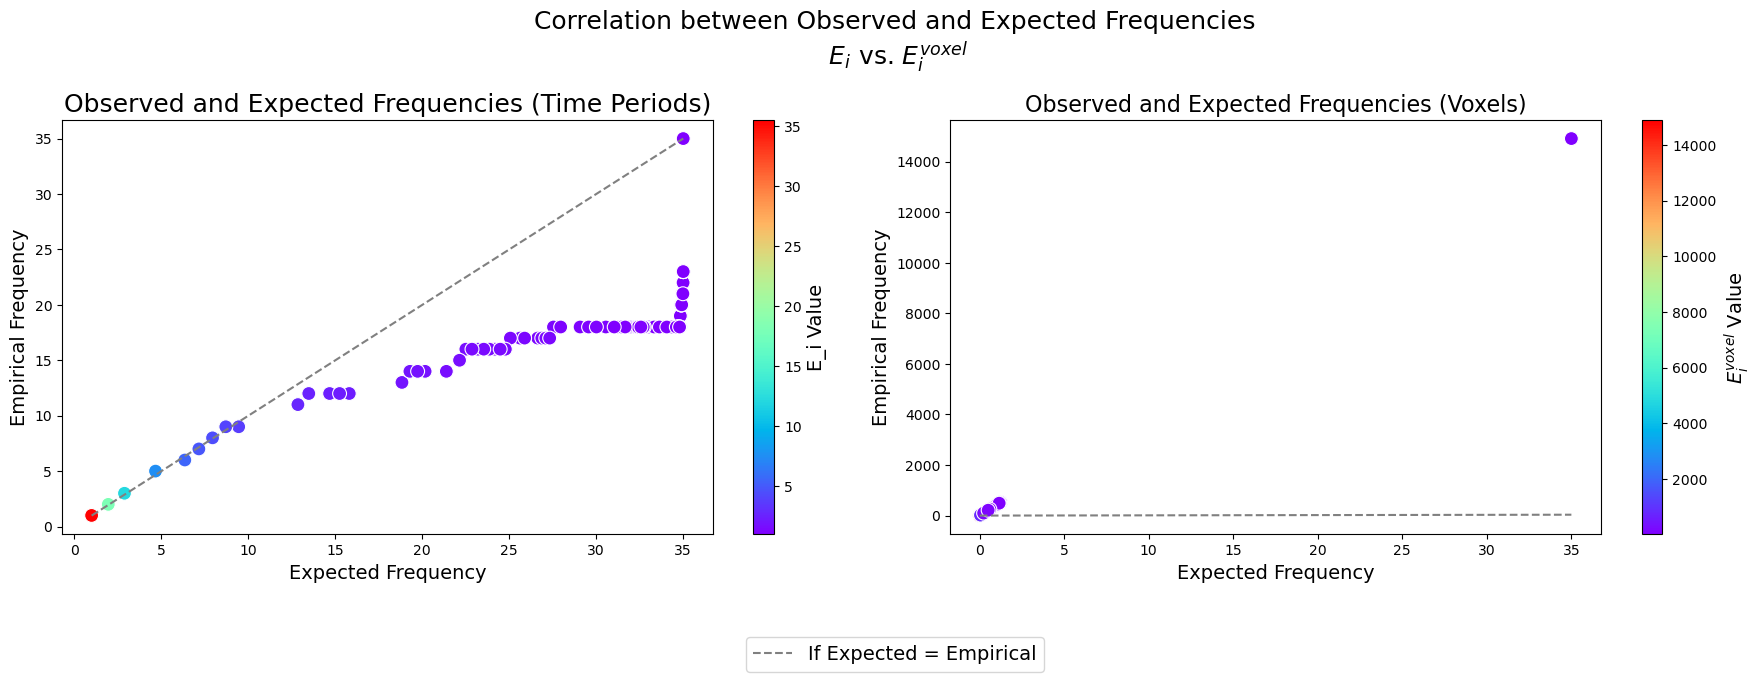

In [24]:

# Example usage
# Assuming time_period_df and voxel_df are the DataFrames containing the comparison of empirical vs expected frequencies
plot_correlation(time_period_df, voxel_df)


### Conclusion of Comparison

Using $E_i$ as the basis for return periods aligns much bettet with the common understanding of return periods. These periods are typically understood as the average time interval between events of a certain magnitude. $E_i$ represents the expected number of time periods to observe at least one voxel with a value greater than or equal to $i$, matching this interpretation.

In contrast, using $E_{i}^{\text{voxels}}$ can be misleading. $E_{i}^{\text{voxels}}$ represents the expected number of individual voxels needed to observe a voxel with a value greater than or equal to $i$. While mathematically valid, this approach confuses the concept of return periods by focusing on the number of voxels rather than the time periods.

#### Key Points of Comparison:

1. **Alignment with Common Understanding**:
   - **$E_i$**: Reflects the average number of time periods between significant events, aligning with the typical interpretation of return periods.
   - **$E_{i}^{\text{voxels}}$**: Reflects the number of individual voxels needed to observe an event beyond a specified size, which can mislead the interpretation of event frequency over time.

2. **Expected vs. Empirical Observations**:
   - Empirical observations for $E_i$ (time periods) show a more consistent pattern with expected frequencies, supporting its use in return period analysis.
   - Empirical observations for $E_{i}^{\text{voxels}}$ demonstrate a higher frequency than expected, illustrating the misleading nature of using voxel-based calculations for return periods.

3. **Practical Implications**:
   - **$E_i$**: Provides a meaningful measure for planning and decision-making, helping to estimate the frequency of observations needed to detect significant events or values.
   - **$E_{i}^{\text{voxels}}$**: While useful in understanding the spatial distribution of events, it does not provide an accurate measure of time-based return periods and can lead to incorrect conclusions about event frequency.

4. **Use Case Context**:
   - In our specific use case (e.g., analyzing fatalities per 100,000 in a PRIO-grid year), using $E_i$ helps identify the average time interval between significant events, aiding in risk assessment and resource allocation.
   - Using $E_{i}^{\text{voxels}}$ might suggest that events occur more frequently than they actually do over time, leading to potential overestimation of risk.

In conclusion, for accurate and meaningful return period analysis, $E_i$ should be used as the basis. This approach aligns with the common understanding of return periods and provides a reliable measure for estimating event frequency over time. In contrast, $E_{i}^{\text{voxels}}$ should be used cautiously and understood as representing spatial, not temporal, return periods. This distinction is crucial for informed decision-making and accurate risk assessment in various applications.

In [25]:
def update_df(data, probabilities):
    """
    Map the expected frequency of time periods (expected_freq_time) to the original data based on the value.
    
    Parameters:
    data (pd.DataFrame): The original voxel data with columns ['cell_id', 'year_id', 'fatalities_per_100k', 'row', 'col']
    probabilities (pd.DataFrame): DataFrame containing values, p_i, P_i, E_i, and E_i_voxels
    
    Returns:
    pd.DataFrame: Original data with an additional column for expected frequency of time periods (expected_freq_time)
    """
    # Merge the probabilities with the original data on the 'value' column to add 'E_i' to the original data
    data = data.merge(probabilities[['value', 'E_i']], left_on='fatalities_per_100k', right_on='value', how='left')
    
    # Calculate the expected frequency of time periods (expected_freq_time)
    data['expected_freq_time'] = 1 / data['E_i']
    
    # Drop the temporary 'value' column
    data = data.drop(columns=['value'])
    
    return data



In [26]:
# Assuming df is the original data and probabilities is the DataFrame with calculated probabilities
df_new = update_df(df, probabilities)

In [37]:
def plot_heatmaps_with_return_periods(data, thresholds, percentiles=False, n_time_periods=9, annot = True):
    """
    Plot a grid of heatmaps for 9 time periods in a 3x3 layout, highlighting observations exceeding specified return periods or percentiles.
    
    Parameters:
    data (pd.DataFrame): The voxel data with columns ['cell_id', 'year_id', 'fatalities_per_100k', 'row', 'col', 'E_i']
    thresholds (list): List of return periods or percentiles to highlight (e.g., [2, 5, 10, 15] or [50, 75, 90, 95])
    percentiles (bool): If True, interpret thresholds as percentiles of return periods; otherwise as absolute return periods
    """
    # Calculate the thresholds if they are percentiles
    if percentiles:
        percentile_thresholds = thresholds.copy()
        thresholds = thresholds.copy()
        thresholds = np.percentile(data['E_i'], thresholds)
        #print(thresholds)

    # Select the 9 most violent years based on the sum of fatalities per 100k
    most_violent_years = data.groupby('year_id')['fatalities_per_100k'].sum().nlargest(n_time_periods).index
    most_violent_years = sorted(most_violent_years)  # Sort the years in chronological order


    # Generate a color map for the thresholds with gray to black shades
    colors = ['#A9A9A9', '#696969', '#505050', '#000000']  # Light Gray, Gray, Dark Gray, Black
    color_map = {threshold: color for threshold, color in zip(thresholds, colors)}

    # Calculate the number of rows needed
    n_rows = (n_time_periods + 2) // 3
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows))
    axes = np.atleast_2d(axes)  # Ensure axes is always 2D

    font_large = 18
    font_mid = 16
    font_small = 14

#    fig, axes = plt.subplots(3, 3, figsize=(18, 18))

    for i, time_period in enumerate(most_violent_years):
        ax = axes[i // 3, i % 3]
        time_slice = data[data['year_id'] == time_period]
        pivot_time_slice = time_slice.pivot(index='row', columns='col', values='fatalities_per_100k')

        pivot_time_slice_E_i = time_slice.pivot(index='row', columns='col', values='E_i')

        sns.heatmap(pivot_time_slice, annot=annot, fmt=".1f", cmap='rainbow', ax=ax, cbar=False, 
                    vmin=data['fatalities_per_100k'].min(), vmax=data['fatalities_per_100k'].max(), annot_kws={"size": 5})

        ax.invert_yaxis()  # Invert the y-axis
        ax.set_title(f'Year {time_period}')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(left=False, bottom=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Highlight individual cells that exceed the return periods or percentiles
        for threshold in thresholds:

            for row in range(pivot_time_slice_E_i.shape[0]):
                for col in range(pivot_time_slice_E_i.shape[1]):
                    if pivot_time_slice_E_i.iloc[row, col] >= threshold:
                        ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor=color_map[threshold], lw=2, linestyle='-'))
                        # Add a cross within the rectangle
                        ax.plot([col, col+1], [row, row+1], color=color_map[threshold], lw=1)
                        ax.plot([col, col+1], [row+1, row], color=color_map[threshold], lw=1)

    # Add a vertical colorbar below the heatmaps
    fig.subplots_adjust(bottom=0.15)  # Adjust bottom to make space for colorbar
    cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # Position for colorbar
    norm = plt.Normalize(data['fatalities_per_100k'].min(), data['fatalities_per_100k'].max())
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.outline.set_visible(False)  # Remove edge color from colorbar
    cbar.set_label('Fatalities per 100,000 capita', fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # Create a custom legend
    if percentiles:
        handles = [plt.Line2D([0], [0], color=color_map[threshold], lw=2, linestyle='-', 
                              label=f'>={threshold:.0f} (percentile = {percentile_thresholds[j]:.4f})') for j, threshold in enumerate(thresholds)]
    else:
        handles = [plt.Line2D([0], [0], color=color_map[threshold], lw=2, linestyle='-', label=f'>={threshold:.0f}') for threshold in thresholds]

    fig.legend(handles=handles, loc='upper right', title='Thresholds\n(return periods in years)', title_fontsize='large', fontsize='large', bbox_to_anchor=(0.99, 0.98))

    # overall title
    fig.suptitle('Conflict index (fatalities per 100k) at the 9 Most Violent Years in Mali.\nHighlighted cells exceed specified return periods.', fontsize=16, y=0.99, x=0.5)

    #plt.tight_layout()
    plt.show()


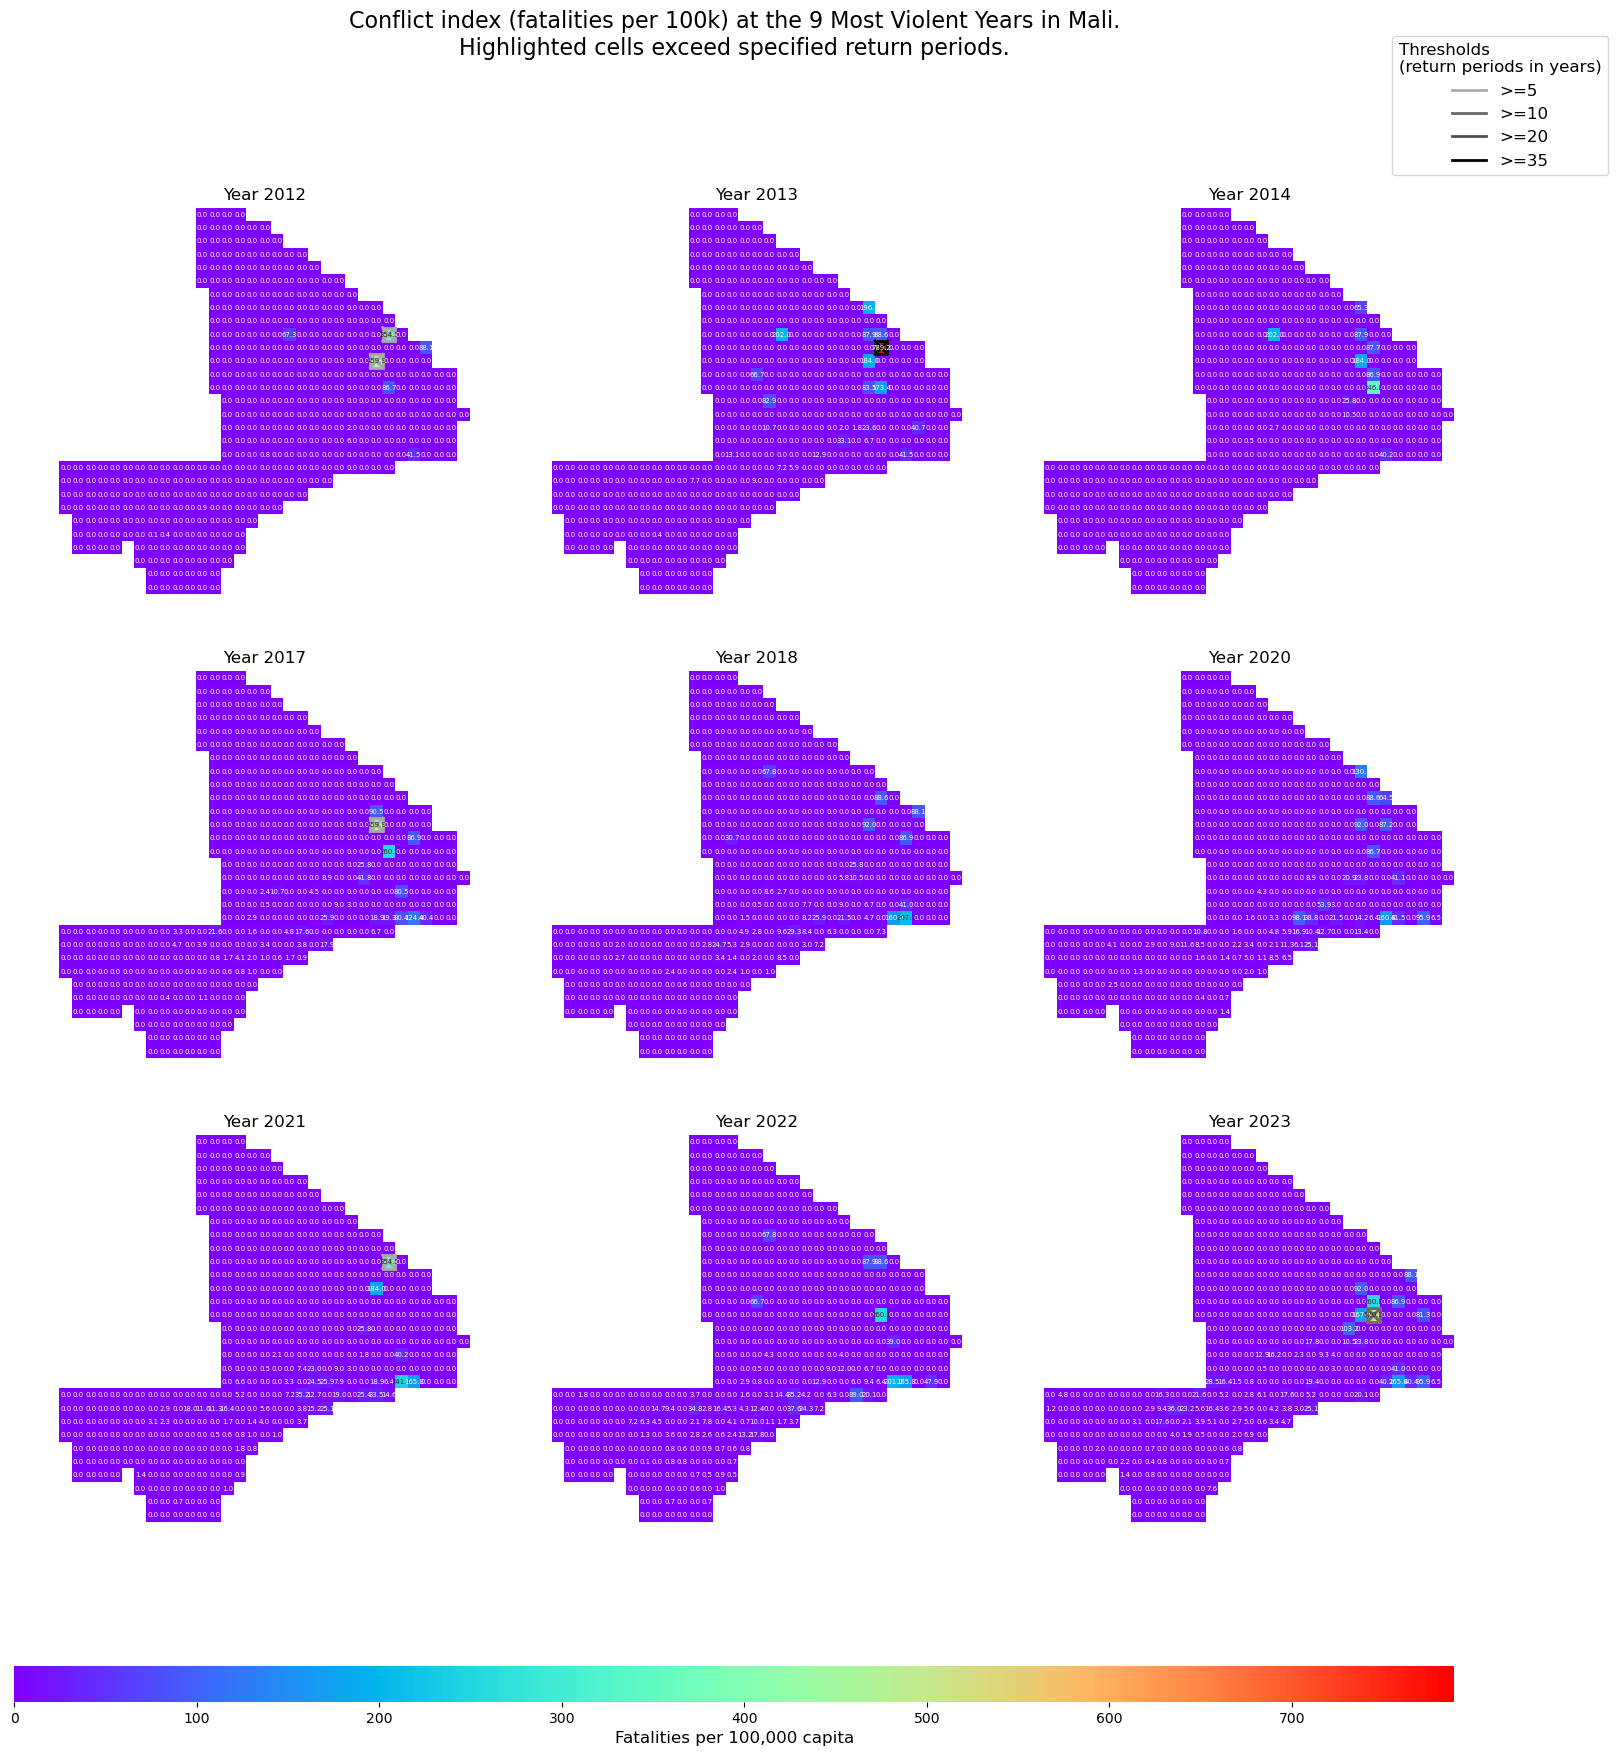

In [28]:
# Example usage
# Assuming df_with_expected_freq is the DataFrame with the new column
thresholds = [5, 10, 20, 35]  # or [50, 75, 90, 95] if using percentiles
plot_heatmaps_with_return_periods(df_new, thresholds, percentiles=False)

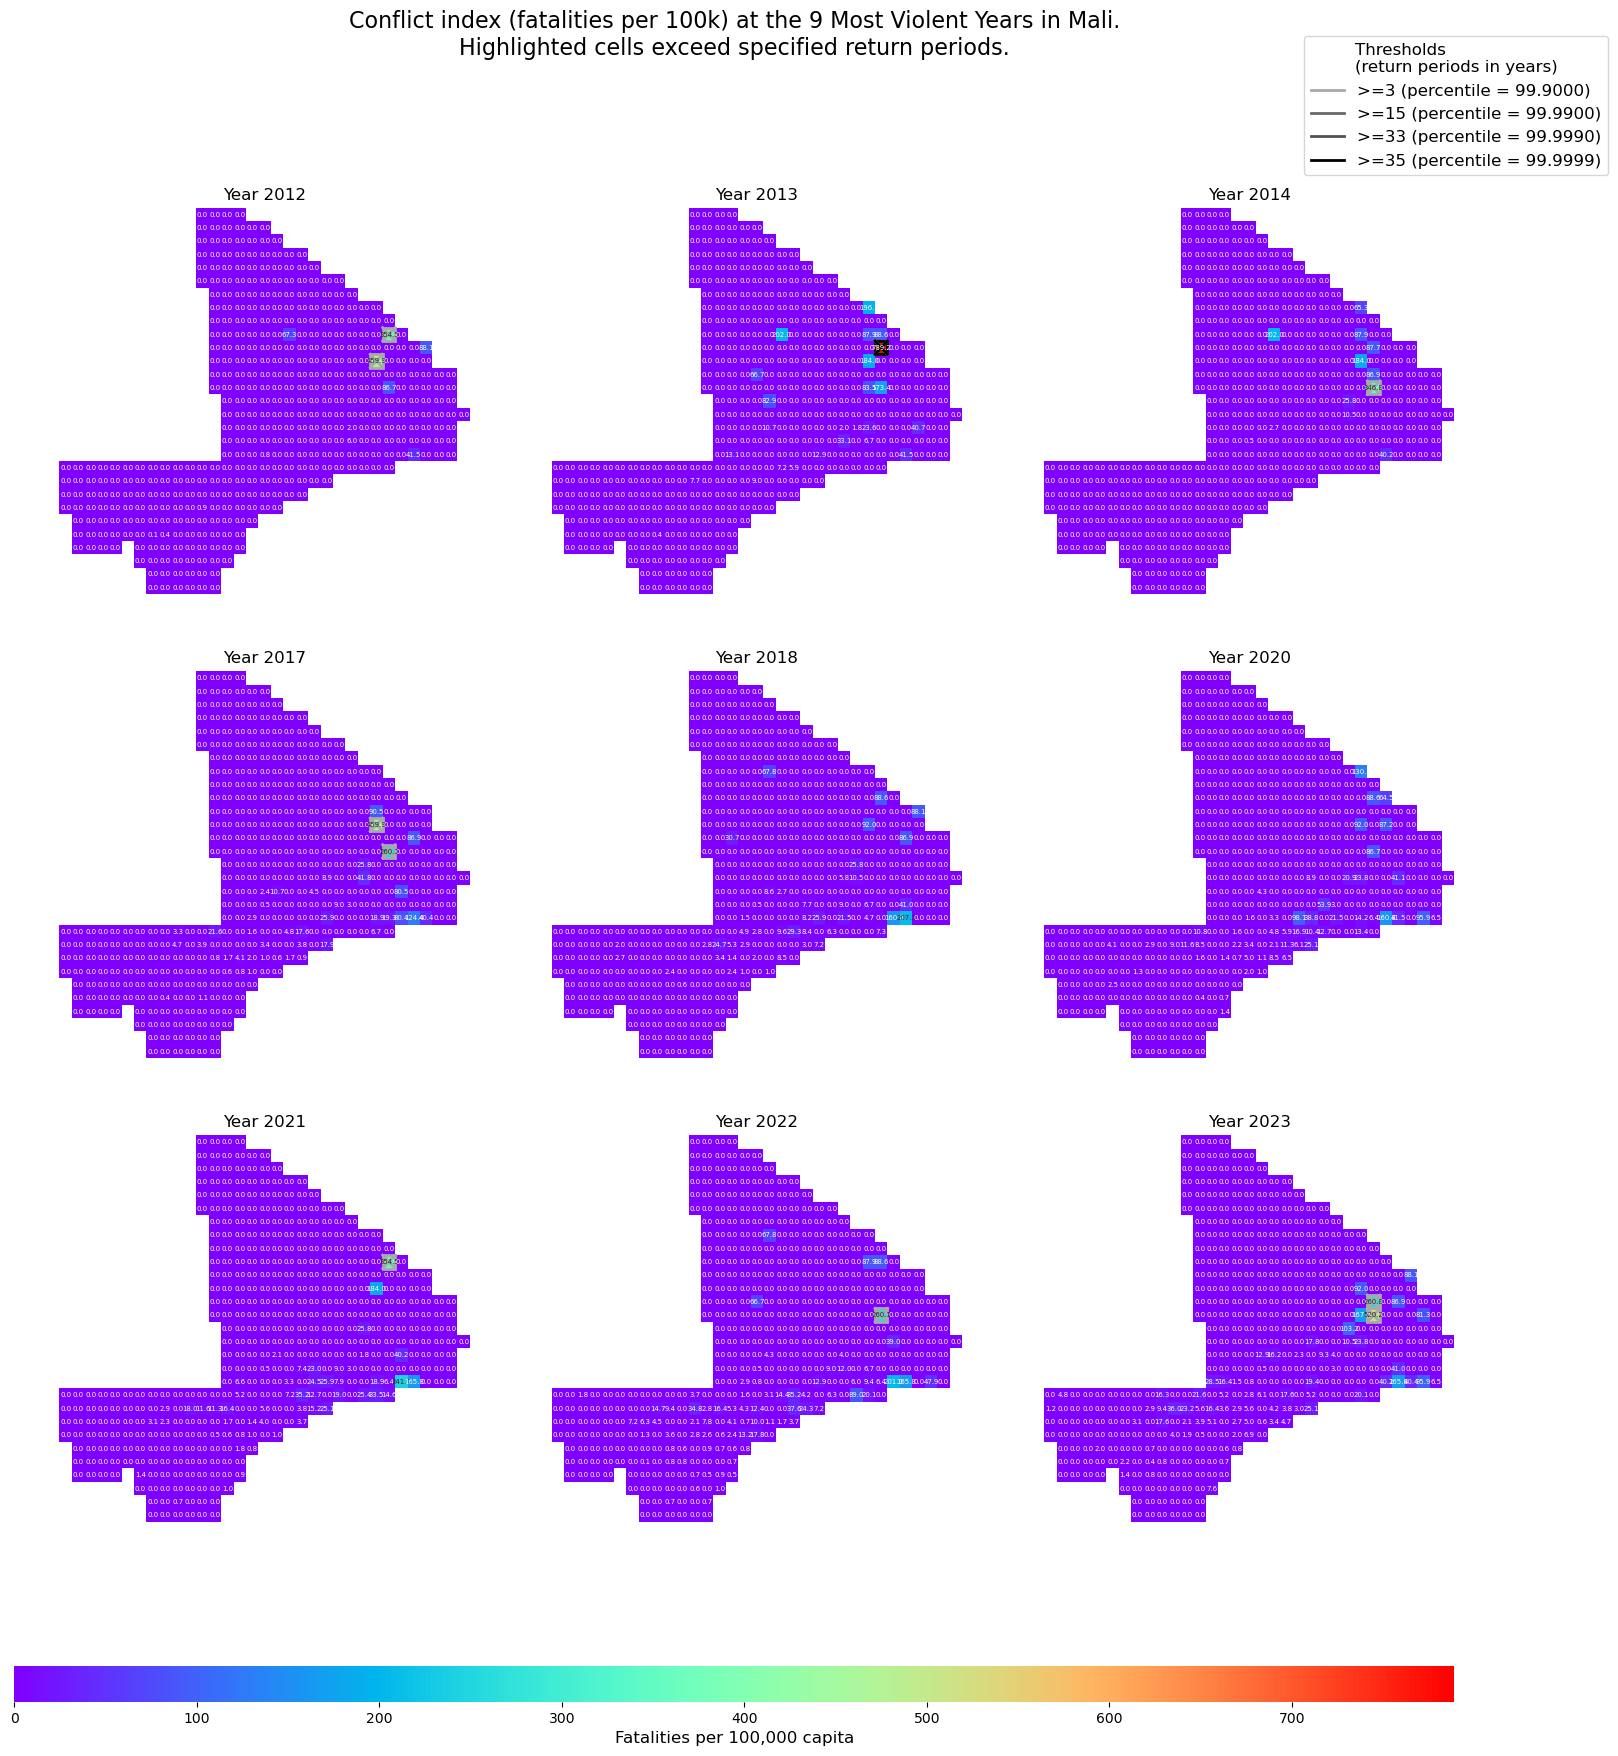

In [29]:
# Example usage
# Assuming df_with_expected_freq is the DataFrame with the new column
thresholds = [99.9, 99.99, 99.999, 99.9999]  # if using percentiles
plot_heatmaps_with_return_periods(df_new, thresholds, percentiles=True)

### Conclusion on Heatmaps with Return Period Highlights

The heatmaps provide a detailed visualization of the spatial distribution of fatalities per 100,000 capita across Mali for the nine most violent years. Each heatmap represents the data for one specific year, arranged chronologically from the top-left to the bottom-right.

#### Key Insights

**Value Distribution**:
The colors in each heatmap correspond to the fatalities per 100,000 capita. Warmer colors indicate higher values, while cooler colors indicate lower values.

**Highlighted Thresholds**:
Rectangles highlight cells where the value of $E_i$ exceeds specified return periods or percentiles. Different shades of gray to black indicate varying levels of exceedance, with darker shades representing higher thresholds. This visual distinction allows for quick identification of regions with significantly high values surpassing critical thresholds.

**Crosses in Highlighted Cells**:
Crosses within the highlighted rectangles provide an additional layer of emphasis, ensuring that these critical cells are easily noticeable.

#### Relevance and Interpretation

**Understanding Return Periods**:
Highlighting cells that exceed specific return periods ($E_i$) shows how often extreme values occur in different regions over time. This is crucial for identifying hotspots and understanding the frequency of severe events. This visualization further justifies using $E_i$ (and not $E_i^{\text{voxels}}$) as the correct conceptualization of "return periods."

**Risk Assessment and Planning**:
These visualizations aid in risk assessment by showing where and when high fatality rates are most likely to occur. Policymakers and planners can use this information to allocate resources more effectively and implement targeted interventions.

**Percentile-Based Analysis**:
If using percentiles, the highlighted cells represent regions where values fall within the top percentile thresholds of return periods. This method allows for a relative comparison across different regions and time periods, identifying areas that consistently experience high fatality rates. The high percentiles observed here are a natural feature of the zero-inflated data and, unlike $E_i^{\text{voxels}}$, do not result from data artifacts.

#### Summary

These heatmaps serve as a powerful visual tool for analyzing the spatial and temporal distribution of high-fatality events in Mali. They highlight regions exceeding critical thresholds, providing valuable insights for effective risk management and policymaking. By using $E_i$ and percentiles, we obtain a more accurate representation of return periods, essential for understanding and mitigating the impacts of severe events. This approach ensures resources can be allocated to areas most in need and interventions can be more precisely targeted.

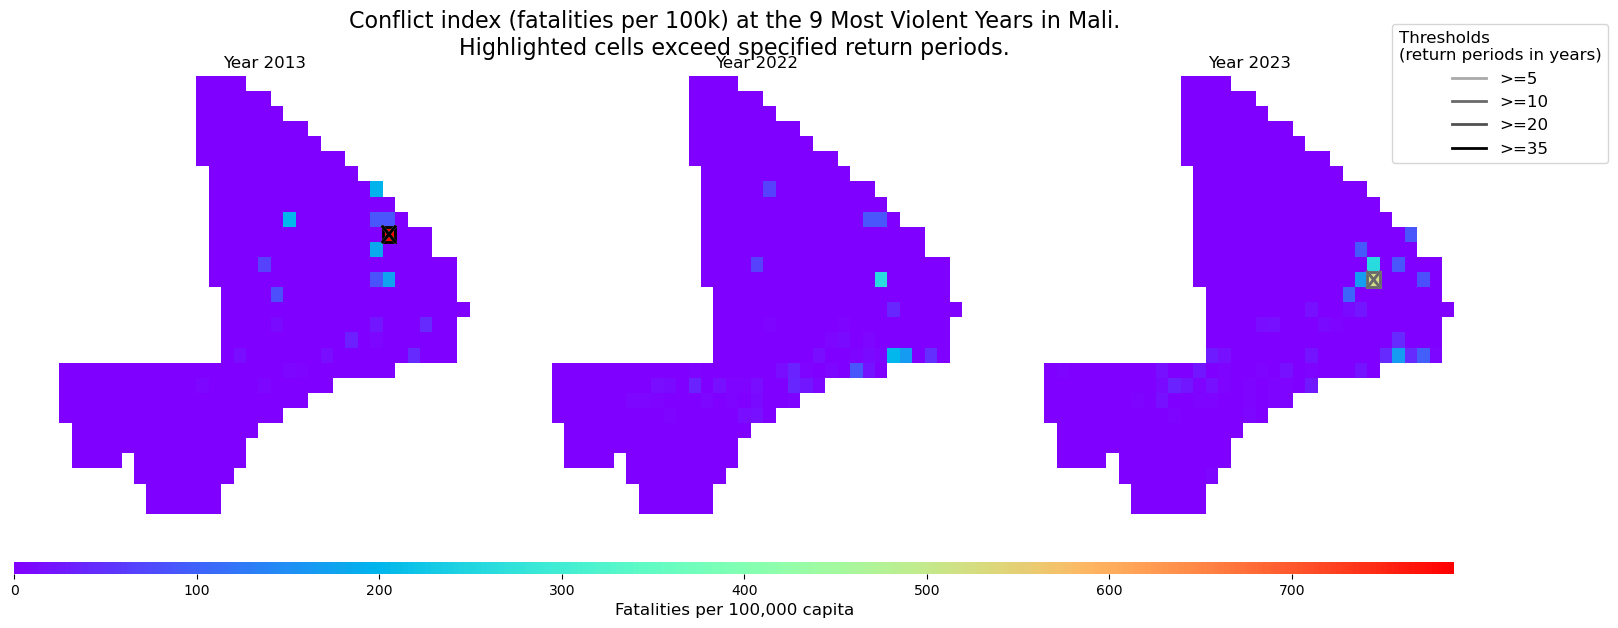

In [30]:
# Example usage
# Assuming df_with_expected_freq is the DataFrame with the new column
thresholds = [5, 10, 20, 35]  # or [50, 75, 90, 95] if using percentiles
plot_heatmaps_with_return_periods(df_new, thresholds, percentiles=False, n_time_periods=3, annot = False)

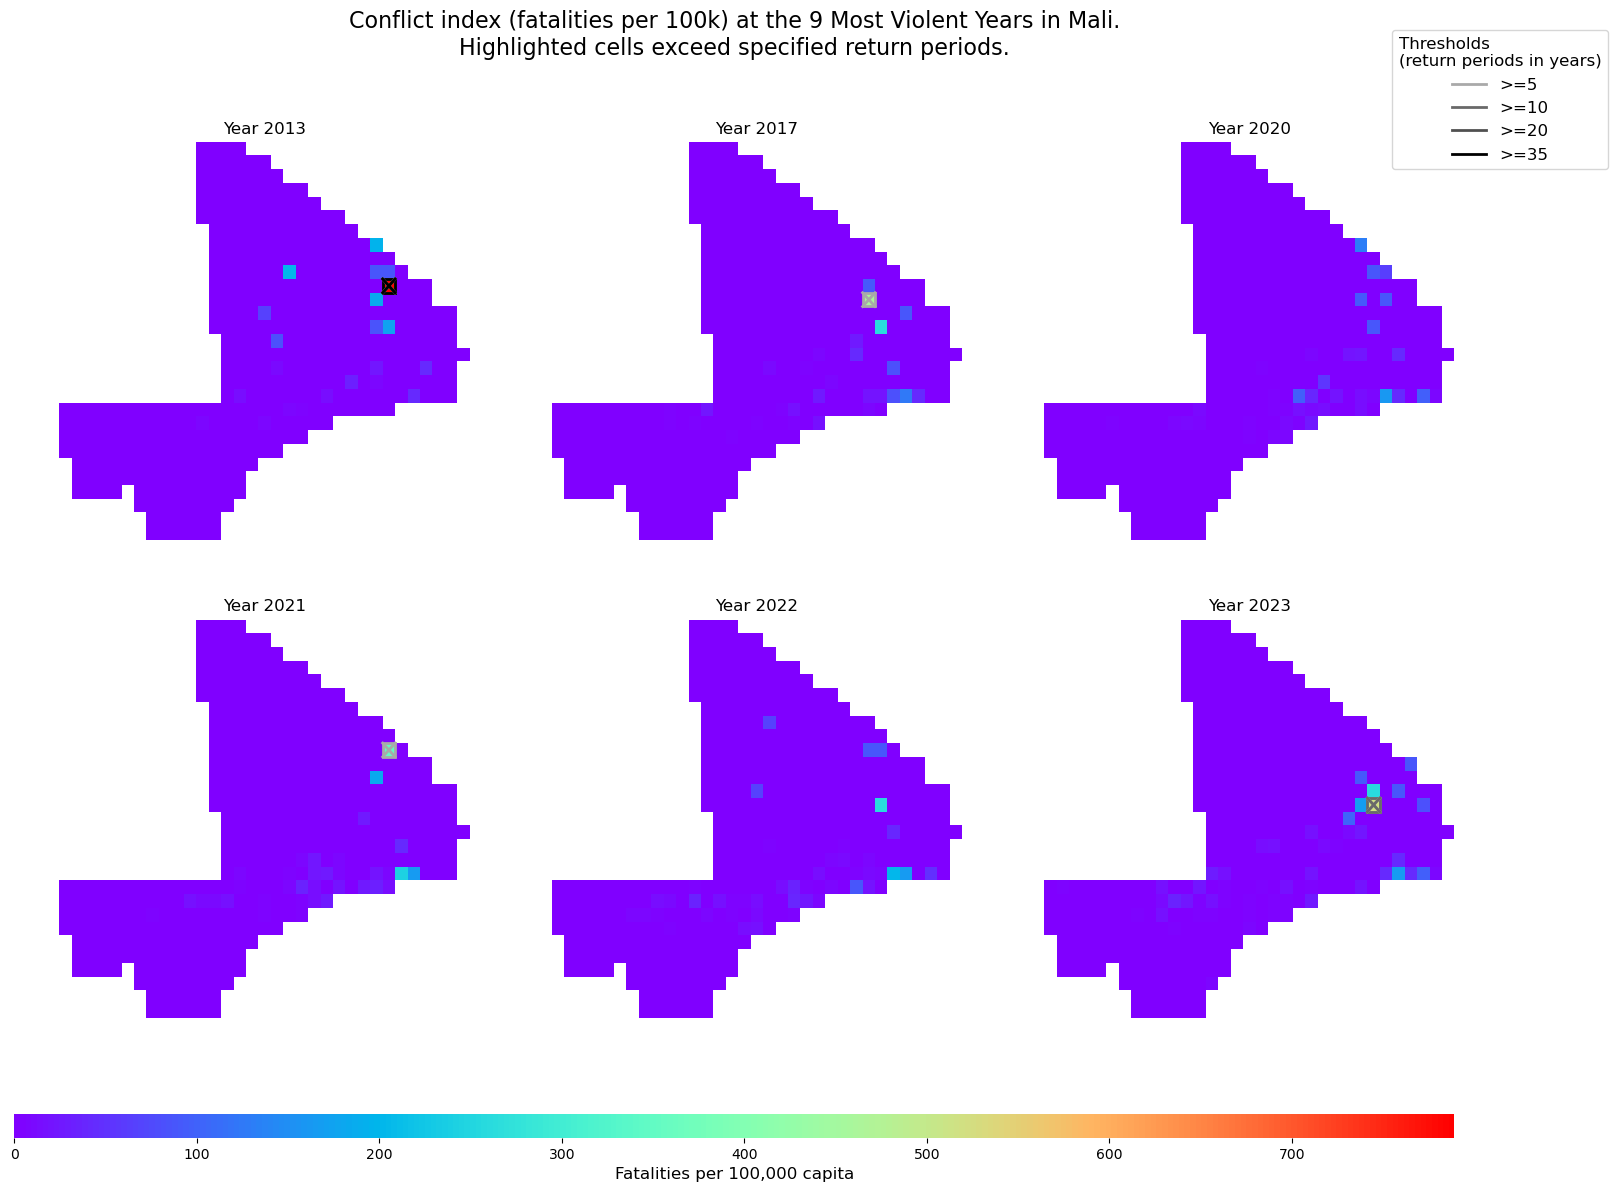

In [31]:
# Example usage
# Assuming df_with_expected_freq is the DataFrame with the new column
thresholds = [5, 10, 20, 35]  # or [50, 75, 90, 95] if using percentiles
plot_heatmaps_with_return_periods(df_new, thresholds, percentiles=False, n_time_periods=6, annot = False)

In [32]:
# save the df_new to a pickle file
df_new.to_pickle('/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/simon_mali_01_viewser_df_processed.pkl')

# and as  csv
df_new.to_csv('/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/simon_mali_01_viewser_df_processed.csv')


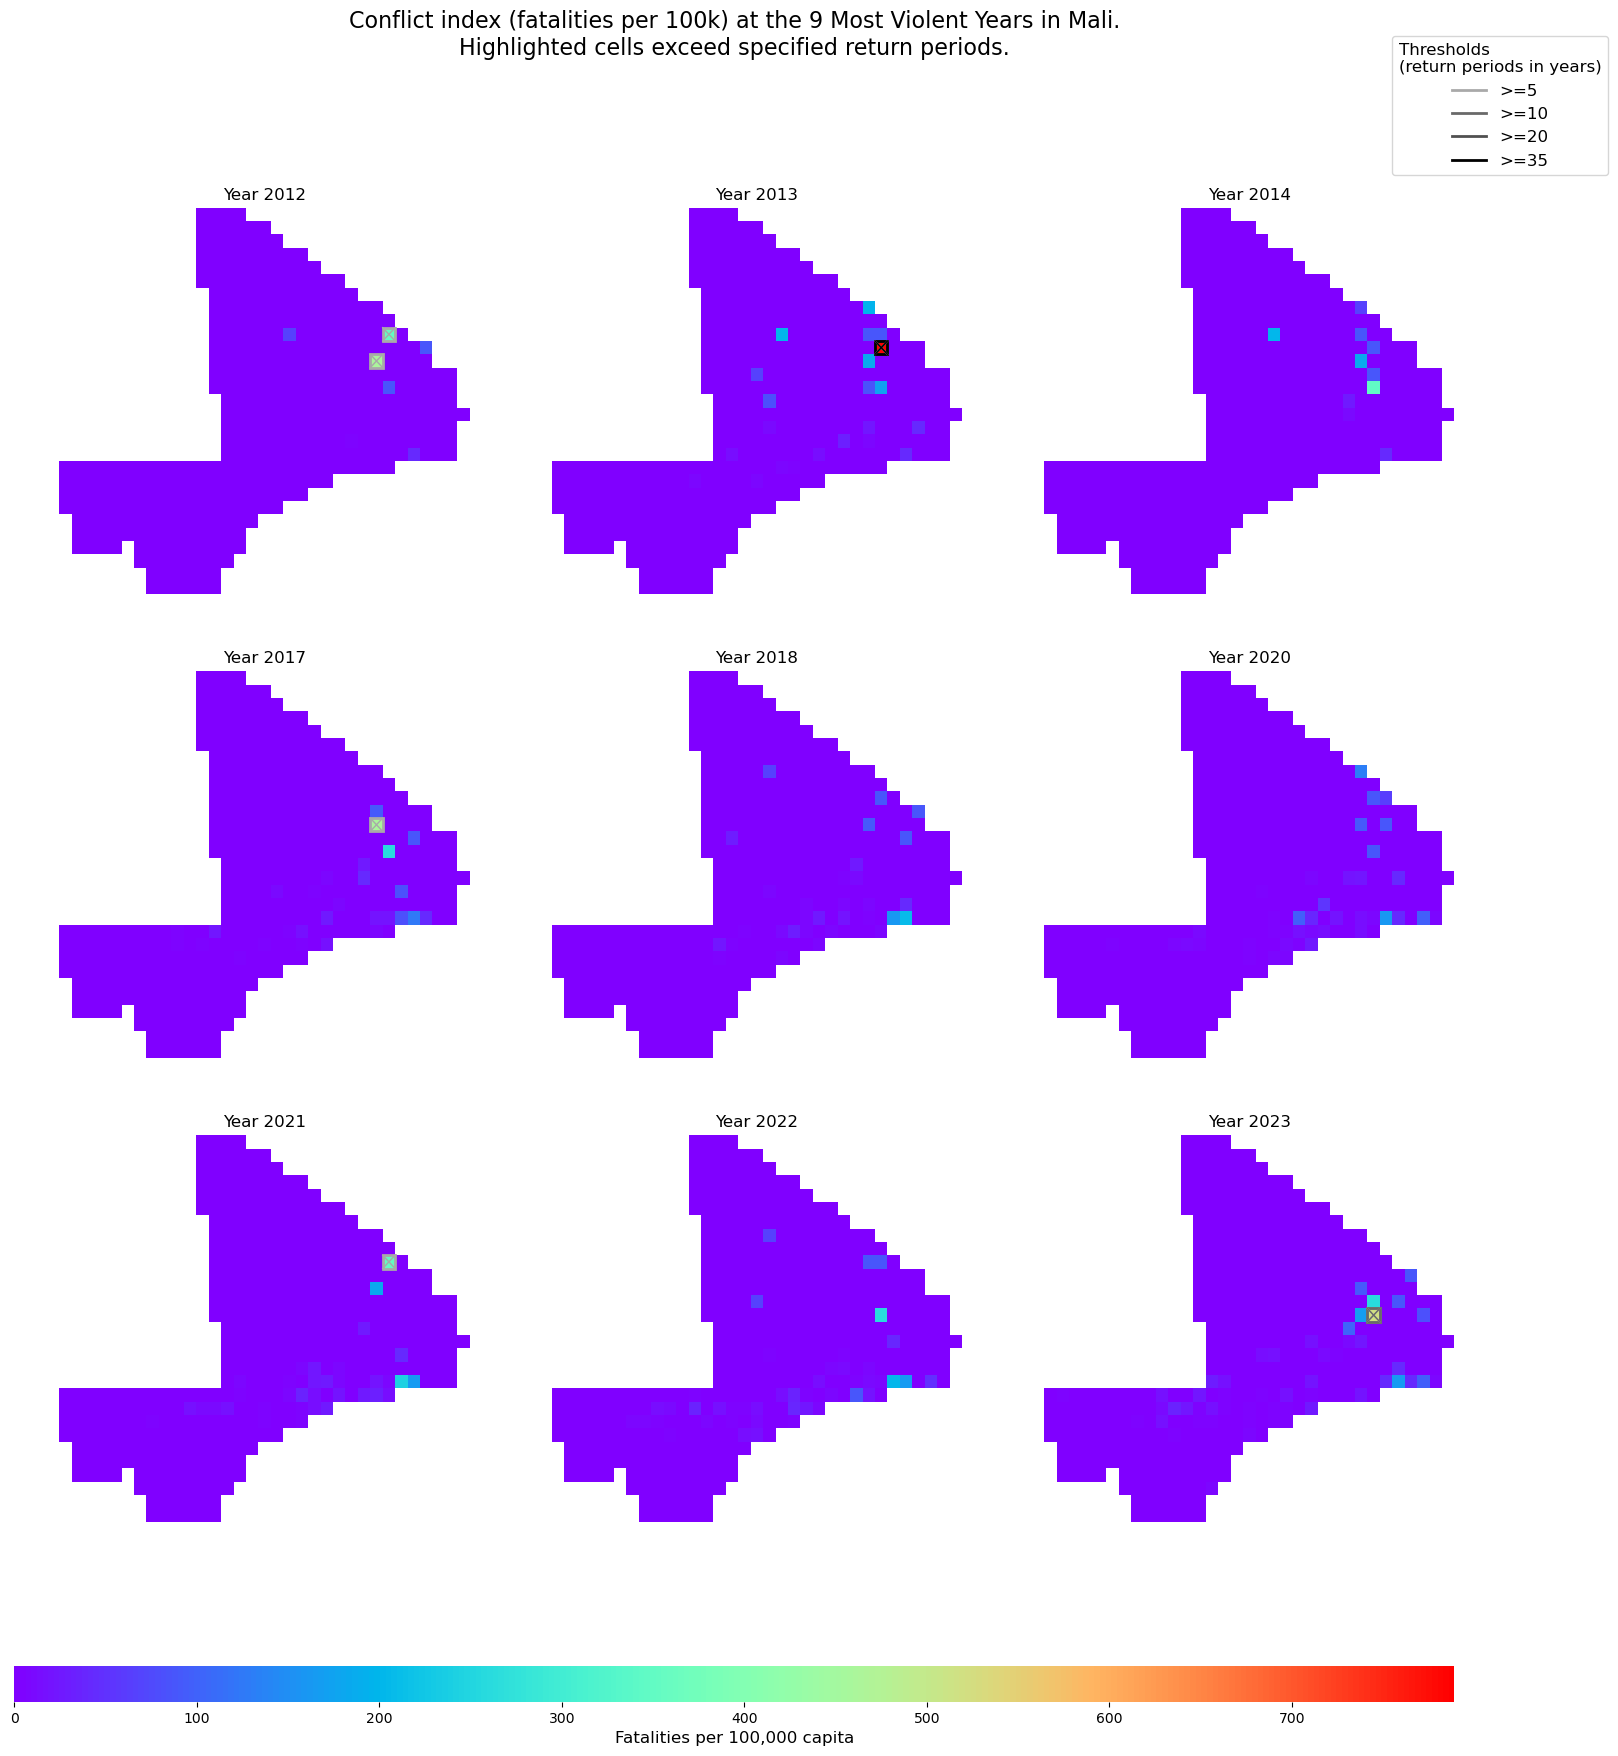

In [38]:
# Example usage
# Assuming df_with_expected_freq is the DataFrame with the new column
thresholds = [5, 10, 20, 35]  # or [50, 75, 90, 95] if using percentiles
plot_heatmaps_with_return_periods(df_new, thresholds, percentiles=False, n_time_periods=9, annot = False)

In [34]:
df[df['year_id'] == 1990]['fatalities_per_100k'].describe()

count    426.000000
mean       1.046956
std       10.966605
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      177.203597
Name: fatalities_per_100k, dtype: float64

In [35]:
# pring out of all the max values given each year
for i in range(1989, 2024):
    print(i, df[df['year_id'] == i]['fatalities_per_100k'].max())

1989 0.0
1990 177.20359659272438
1991 10.40391471675393
1992 151.17375570453947
1993 0.0
1994 15.03245483510689
1995 5.346454981857034
1996 0.0
1997 0.0
1998 0.0
1999 0.0
2000 0.0
2001 0.0
2002 0.0
2003 0.0
2004 0.0
2005 97.64996397727158
2006 0.0
2007 560.0050950984402
2008 183.0493855712305
2009 89.78404044841166
2010 13.46342808987811
2011 6.1138275274925205
2012 459.8999470598572
2013 789.1763132788485
2014 346.7698905359377
2015 260.0774179019533
2016 275.9399682359143
2017 459.8999470598572
2018 207.25394893153404
2019 331.60631829045445
2020 160.79418824795084
2021 354.48889631253877
2022 260.0774179019533
2023 520.1548358039066
